In [ ]:
#|default_exp xrf_physics 

# Theoretical peak patterns   

> Predicting elemental XRF (X-Ray Fluorescence) spectra  

In order to unravel measured X-Ray Fluorescence (XRF) spectra it is most useful to be able to compute the theoretical spectral emission patterns for individual elements. As we will see, each chemical element has a unique peak pattern. Let's skip the theoretical background and simply plot such an XRF spectrum.  If you are interested in the physics behind this, you can find the gory details in the next section. For now, simply import `ElementXRF()` and instantiate it for lead **'Pb'**. 

In [1]:
from moseley import ElementXRF

Plotting a theoretical X-ray fluorescence spectrum can be done with the `.plot_spectrum()` method. 

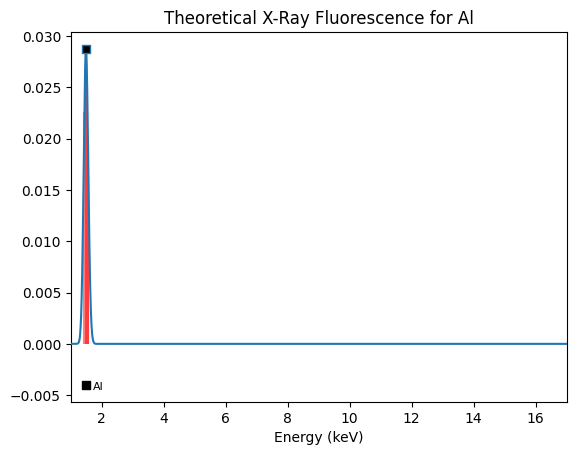

In [125]:
# instantiate the element XRF 
Pb_xrf = ElementXRF('Al') 

# plot the spectrum 
ax = Pb_xrf.plot_spectrum(facecolor='k', xlim=[1, 17], vlines_colors='r') 

# add Pb emission pattern below the spectral plot 
ptrn_dict = Pb_xrf.get_pattern_dict() 
plot_pattern(ptrn_dict, ax=ax, offset=-0.004, color='k');

We can see here that this XRF spectrum (blue with black markers) for lead consists of multiple Gaussian shaped peaks. Most of these peaks are the result of closely spaced emission lines. Each emission line corresponds to a specific transition of an electron between different electron shells. If you want to inspect these transitions in detail you can inspect the `.lines_table` attribute.  

In [123]:
Pb_xrf.lines_table

,name,label,energy,trans_prob,fluo_yield,jump_coeff,intensity
0,Lb4,Pb_L1M2,12.3070,0.338604,0.112000,0.135060,0.005122
1,Lb3,Pb_L1M3,12.7950,0.401364,0.112000,0.135060,0.006071
2,Lg2,Pb_L1N2,15.0991,0.114773,0.112000,0.135060,0.001736
3,Lg3,Pb_L1N3,15.2175,0.145259,0.112000,0.135060,0.002197
4,Ln,Pb_L2M1,11.3490,0.018116,0.373000,0.285714,0.001931
5,Lb1,Pb_L2M4,12.6140,0.787801,0.373000,0.285714,0.083957
6,Lg1,Pb_L2N4,14.7657,0.165149,0.373000,0.285714,0.017600
7,Lg6,Pb_L2O4,15.1793,0.028934,0.373000,0.285714,0.003083
8,Ll,Pb_L3M1,9.1840,0.037951,0.360000,0.600958,0.008210
9,La2,Pb_L3M4,10.4490,0.076339,0.360000,0.600958,0.016516


## FUNCTIONS 

In [43]:
#|export 

import numpy as np 
import xraydb 
import pandas as pd 
import scipy.signal as ssg 
import scipy.interpolate as sip
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mendeleev

In [107]:
#|export 

class ElementXRF(): 
    '''Computes fluorescence emission line energies and intensities for `element`. 
    
    '''
    
    def __init__(self, element, excitation_energy_keV=None, tube_anode='Rh', x_keVs=None, std=0.01, min_prom=0.001): 
        

        ### LINES ### 

        if (excitation_energy_keV is None) and (tube_anode=='Rh'): 
            excitation_energy_keV = 23 

        self.element = element 

        excitation_energy = 1000 * excitation_energy_keV # keV -> eV 

        lines = xraydb.xray_lines(element, excitation_energy=excitation_energy) 

        line_names = [] # Siegbahn notation
        line_labels = [] # IUPAC notation 
        line_energies = [] 
        line_probabilities = [] 

        line_fluo_yields = []
        line_jump_coeffs = [] 
        line_intensities = []
        
        for name, line in lines.items(): 

            # xraydb 'intensities' (a.k.a. transition probablities) sum up to unity within each level 
            energy, probability, initial_level, final_level = line  
            label = f'{element}_{initial_level}{final_level}' #  construct IUPAC notation 
            
            # get corresponding edge properties 
            edge = initial_level # IUPAC notation!  e.g. 'L1', not 'La'
            edge_energy, fluo_yield, jump_ratio = xraydb.xray_edge(element, edge) 
            jump_coeff = (jump_ratio - 1) / jump_ratio # see Volker Thomsen 
            #print(f'{name}: {energy}; jump_coeff: {jump_coeff:.03f}; fluo_yield: {fluo_yield}')

            # multiplying edge jump coefficient, transition probability and fluorescence yield... 
            intensity = jump_coeff * probability * fluo_yield 

            line_names.append(name) 
            line_labels.append(label)
            line_energies.append(energy / 1000)
            line_probabilities.append(probability)  
            
            line_fluo_yields.append(fluo_yield)
            line_jump_coeffs.append(jump_coeff) 
            line_intensities.append(intensity) 

        self.lines_table = pd.DataFrame({'name': line_names, 
                                         'label': line_labels, 
                                         'energy': line_energies, 
                                         'trans_prob': line_probabilities, 
                                         'fluo_yield': line_fluo_yields, 
                                         'jump_coeff': line_jump_coeffs, 
                                         'intensity': line_intensities}) 

    
        ### CONTINUOUS ### 
        
        self.spectrum_xy = gaussian_convolve(line_energies, line_intensities, x_keVs=x_keVs, std=std) 
        self.peaks_xy = find_peaks(*self.spectrum_xy, min_prom=min_prom) 

    def plot_spectrum(self, ax=None, edgecolor=None, facecolor=None, vlines_colors=None, xlim=[0, 25]): 
        
        if edgecolor is None: 
            edgecolor = cm.tab20(0)
        if facecolor is None: 
            facecolor = 'w' 
    
        if ax is None: 
            fig, ax = plt.subplots() 
    
        x, y = self.spectrum_xy 
        peaks_x, peaks_y = self.peaks_xy.T
    
        ax.plot(x, y, color=edgecolor, zorder=9)
        ax.scatter(peaks_x[0], peaks_y[0], marker='s', facecolor=facecolor, edgecolor=edgecolor, zorder=10)  
        ax.scatter(peaks_x[1:], peaks_y[1:], marker='o', facecolor=facecolor, edgecolor=edgecolor, zorder=10)
    
        # need to interpolate spectrum to add vlines 
    
        spectrum = sip.interp1d(x, y)
        line_keVs = self.lines_table['energy'] 
    
        line_heights = spectrum(line_keVs)
    
        ax.vlines(line_keVs, np.zeros_like(line_keVs), line_heights, colors=vlines_colors, alpha=0.5, zorder=8) 

        ax.set_title(f'Theoretical X-Ray Fluorescence for {self.element}') 
        ax.set_xlabel('Energy (keV)')
        ax.set_xlim(xlim)
        
        return ax 

    def get_pattern_dict(self): 
    
        alpha_keV = float(self.peaks_xy[0][0])
        alpha_escape_keV = alpha_keV - 1.74  # Silicon detector escape energy shift 
        
        # element   
        elem = self.element
        name = mendeleev.element(elem).name
        atomic_number = mendeleev.element(elem).atomic_number
        
        ptrn_dict = {'elem': elem,  
                     'atomic_number': atomic_number, 
                     'alpha_keV': alpha_keV, 
                     'name': name, 
                     'peaks_xy': self.peaks_xy, 
                     'alpha_escape_keV': alpha_escape_keV} 
        
        return ptrn_dict
    
def get_element_spectra(elements, x_keVs, excitation_energy_keV): 
    '''Compute theoretical emission spectrum for multiple elements. 
    
    Sorts elements according to largest (alpha) peak. Based on xraydb. 
    
    Returns: elements, element_spectra
    '''

    n_channels = len(x_keVs)
    n_elements = len(elements)

    element_spectra = np.zeros([n_elements, n_channels]) 

    for i, elem in enumerate(elements): 
        element_spectra[i] = get_element_spectrum(elem, excitation_energy_keV, x_keVs=x_keVs)

        # normalize
        element_spectra[i] = element_spectra[i] / element_spectra[i].max()


    # sort according to energy of largest (=alpha) peak
    alpha_idxs = np.argmax(element_spectra, axis=1)
    alpha_order = np.argsort(alpha_idxs) 

    elements = [elements[i] for i in alpha_order]
    element_spectra = element_spectra[alpha_order]
    
    return elements, element_spectra 


def gaussian_convolve(peak_energies, peak_intensities, x_keVs=None, std=0.01): 
    '''Convolves line spectrum defined by `peak_energies` and `peak_intensities` 
    
    with a Gaussian peak shape.'''
    
    if x_keVs is None: 
        x_keVs = np.linspace(0, 40, 10000)

    y_spectrum = np.zeros_like(x_keVs) 

    for peak_energy, peak_intensity in zip(peak_energies, peak_intensities): 

        y_spectrum += peak_intensity * np.exp(-(1 / std) * (x_keVs - peak_energy)**2)
        
    return x_keVs, y_spectrum  

def find_peaks(x, y, min_prom=0.001):  
    '''Find peaks in spectrum `x`, `y` with minimal prominence `min_prom=`
    
    Returns: peaks_xy''' 
    
    # find the peaks (channel indexes) 
    peaks, props = ssg.find_peaks(y, prominence=[min_prom, None])

    peaks_x = x[peaks]
    peaks_y = y[peaks] 
    
    # sort according to peak_height 
    sort_idxs = np.argsort(peaks_y)[::-1] 

    peaks_x = peaks_x[sort_idxs]
    peaks_y = peaks_y[sort_idxs]
    
    peaks_xy = np.c_[peaks_x, peaks_y]

    return peaks_xy 

def plot_pattern(ptrn_dict, ax=None, offset=0, color=None): 
    '''Plot a single element peak pattern. 
    ''' 
        
    element = ptrn_dict['elem']
    
    x, _ = ptrn_dict['peaks_xy'].T
    y = np.zeros_like(x) + offset 
    alpha_escape_keV = ptrn_dict['alpha_escape_keV']
         
    left_x = min(x)
    right_x = max(x) 

    if color is None: 
        facecolor = 'w'
        edgecolor = 'grey'
        linecolor = 'grey'
        linestyle = ':'

    else: 
        facecolor = color 
        edgecolor = 'k'
        linecolor = color
        linestyle = '-'

    if ax is None: 
        fig, ax = plt.subplots() 

    ax.scatter(x, y, s=15, facecolor=facecolor, edgecolor=edgecolor)
    ax.scatter(x[0], y[0], marker='s', facecolor=facecolor, edgecolor=edgecolor)
    ax.plot([left_x, right_x], [y[0], y[0]], color=edgecolor, linestyle=linestyle, zorder=-10)
    ax.scatter(alpha_escape_keV, y[0], marker='|', color=edgecolor) 
    ax.annotate(element, [right_x, y[0]], xytext=[5, -1], fontsize=8, color='k', 
                textcoords='offset points', ha='left', va='center') 
   
    return ax 

In [54]:
ptrn_dict = Pb_xrf.get_pattern_dict()
ptrn_dict

{'elem': 'Pb',
 'atomic_number': 82,
 'alpha_keV': 10.545054505450546,
 'name': 'Lead',
 'peaks_xy': [array([10.54505451, 12.60926093, 14.76547655,  2.36423642,  9.18491849,
         15.17751775, 12.30123012, 13.01330133, 11.34913491]),
  array([0.15392372, 0.1204257 , 0.0176001 , 0.01608584, 0.00820976,
         0.00589389, 0.0053041 , 0.00475172, 0.00193063])],
 'alpha_escape_keV': 8.805054505450546}

In [116]:
%matplotlib widget

# More ideas 

## Absorption and scattering 

The xraydb documentation gives an example calculation for different mass attenuation cross sections.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from xraydb import mu_elam 

In [ ]:
energy = np.arange(500, 25000, 10)  # energy in eV
energy_keV = energy / 1000 


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[9, 7], sharex=True, sharey=True) 
axs = axs.flatten()

elements = ['C', 'Ca', 'Fe', 'Pb']

for i, elem in enumerate(elements):       

    mu_total = mu_elam(elem, energy, kind='total')
    mu_photo = mu_elam(elem, energy, kind='photo')
    mu_incoh = mu_elam(elem, energy, kind='incoh')
    mu_coher = mu_elam(elem, energy, kind='coh')


    ax = axs[i]

    ax.set_title(f'X-ray mass attenuation for {elem}')
    ax.plot(energy_keV, mu_total, linewidth=2, label='Total', alpha=0.5)
    ax.plot(energy_keV, mu_photo, linewidth=2, label='Photo-electric', alpha=0.5)
    ax.plot(energy_keV, mu_incoh, linewidth=2, label='Incoherent', alpha=0.5)
    ax.plot(energy_keV, mu_coher, linewidth=2, label='Coherent', alpha=0.5)

    ax.set_xlabel('Energy (keV)')
    ax.set_ylabel(r'$\mu/\rho \rm\, (cm^2/gr)$')
    #ax.legend()
    ax.set_yscale('log')
    
axs[0].legend();

..

I would like to see how scattering depends on atomic number $Z$.

In [ ]:
Z0 = xraydb.atomic_number('H')
Z1 = xraydb.atomic_number('Pb') + 1
element_list = [xraydb.atomic_symbol(Z) for Z in range(Z0, Z1)]
print(element_list)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb']


In [ ]:
energy = np.arange(500, 25000, 10)  # energy in eV
energy_keV = energy / 1000  

elements = element_list

print(elements)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb']


In [ ]:
mu_incoh_list = []
mu_coh_list = []
mu_photo_list = []

for elem in elements: 
    
    mu_incoh = xraydb.mu_elam(elem, energy, kind='incoh')
    mu_incoh_list.append(mu_incoh)
    
    mu_coh = xraydb.mu_elam(elem, energy, kind='coh')
    mu_coh_list.append(mu_coh)
    
    mu_photo = xraydb.mu_elam(elem, energy, kind='photo')
    mu_photo_list.append(mu_photo)


K = np.array(mu_photo_list)
S = np.array(mu_coh_list) + np.array(mu_incoh_list) # ignore Compton shift 

In [ ]:
cmap = plt.get_cmap('viridis_r')
gradient = np.linspace(0, 1, len(elements))
colors = cmap(gradient)

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[9, 4])

for i, mu in enumerate(mu_incoh_list): 
    ax0.plot(energy_keV, mu, label=elements[i], color=colors[i]) 
    ax0.set_xlabel('energy (keV)')
    
for i, mu in enumerate(mu_coh_list): 
    ax1.plot(energy_keV, mu, label=elements[i], color=colors[i])
    ax1.set_xlabel('energy (keV)')
    
for i, mu in enumerate(mu_photo_list): 
    ax2.plot(energy_keV, mu, label=elements[i], color=colors[i])
    ax2.set_xlabel('energy (keV)')

ax0.set_title('incoh')    
ax1.set_title('coh')    
ax2.set_title('photo')  

logscale = True 
if logscale == True:
    ax0.set_yscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
#ax.legend()

..

The question now is if we can explain the lead shadow regions in some of light element peak maps. This problem is essentially combining the effects of scattering and absorption of a translucent layer. To calculate reflectance and transmission properties of such a system we can use the results of Kubelka-Munk theory. 

Given the relatively small energy shift due to inelastic (incoherent) scattering, we can simplify the problem by summing elastic (coherent) and inelastic (incoherent) scattering into a single scattering coefficient $S$. 

In [ ]:
def R_inf(K, S): 
    '''Infinite reflectance from `K` and `S`.
    
    Calculation with modified Saunderson equation. '''
     
    Rinf =  (S/K) / ((S/K) + 1 + np.sqrt(1 + 2 * (S/K))) 
    
    return Rinf 

In [ ]:
Rinf = R_inf(K, S)

In [ ]:
Rinf.shape

(82, 2450)

In [ ]:
fig, ax = plt.subplots()

extent = [energy_keV.min(), energy_keV.max(), Z0, Z1]

im = ax.imshow(Rinf, interpolation='none', origin='lower', aspect=0.3, extent=extent, cmap='Greys_r')

fig.colorbar(im, ax=ax)

ax.set_title(r'Pure element infinite reflectance $R_{\infty}$')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Atomic number (Z)'); 
#ax.set_ylim([0, 20])

..

What we learn here is that the Compton ridge is essentially only due to the abundance of hydrogen in the paper. The scattering of carbon and oxygen can safely be neglected. 

Next step is the calculation of the transmission of a typical ( $200 ~ g/m^2$) paper... 

In [ ]:
mu_paper = xraydb.material_mu('C6H12O6', energy, 0.5)
mu_lead = xraydb.material_mu('PbCO3', energy, 20)
mu_iron = xraydb.material_mu('Fe', energy, 10)

In [ ]:
d_paper = 0.5 # mm 
d_lead = 0.001 # mm 
d_iron = 0.001 # mm 

T_paper = np.exp(-d_paper * mu_paper)
T_lead = np.exp(-d_lead * mu_lead)
T_iron = np.exp(-d_iron * mu_iron)

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])

ax.plot(energy_keV, T_paper, label=f'{d_paper}mm paper')
ax.plot(energy_keV, T_lead, label=f'{d_lead}mm lead')
ax.plot(energy_keV, T_iron, label=f'{d_iron}mm iron')
ax.set_title('Transmission')
ax.set_xlabel('energy (keV)')
ax.set_ylabel('transmission')
ax.legend();

..

So, the one million dollar question now is: what is the expected reflectance of the sandwich? 